## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
# os.environ["KERAS_BACKEND"] = "theano"
# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["THEANO_FLAGS"]  = "device=cuda"
import numpy as np
# import theano as th
# import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
import cmath

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Configuration

In [4]:
SNR_LOWER_ACCEPTANCE_TRESHOLD = 10 # db
TRAINING_SET_DIMENSION = 0.8
DROPOUT_RATE = 0.5

# Dataset setup

In [5]:
# Load the dataset ...
#  You will need to seperately download or generate this file

dataset_file = pickle.load(open("data/RML2016.10a_dict.pkl",'rb'), encoding='bytes')

# snrs = [10, 12, 14, 16, 18]
# mods = [8PSK, AM-DSB, AM-SSB, BPSK, CPFSK, GFSK, PAM4, QAM16, QAM64, QPSK, WBFM]
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset_file.keys())))), [1,0])

signals = []
labels = []

def transform_signals_in_module_phase(signals_to_transform):
    result = []
    
    for signal in signals_to_transform:
        # conversion from I/Q sample to Module/Phase
            I = signal[0]
            Q = signal[1]
            
            modules = []
            phases = []
            
            for j in range(0, len(I)):
                complex_number = complex(I[j], Q[j])
                module = abs(complex_number)
                phase = cmath.phase(complex_number)
                
                modules.append(module)
                phases.append(phase)
            
            # saving module and phase in the new signal
            transformed_signal = []
            transformed_signal.append(modules)
            transformed_signal.append(phases)

            result.append(transformed_signal)
        
    return result


for mod in mods:
    for snr in snrs:
        transformed_signals = transform_signals_in_module_phase(dataset_file[(mod, snr)])
        signals.append(transformed_signals)
        for i in range(dataset_file[(mod, snr)].shape[0]):  labels.append((mod, snr))
        
signals = np.vstack(signals)

# signals = [[[I_0],[Q_0]], [[I_1],[Q_1]], ..., [[I_N],[Q_N]]]
# labels = [(<MODULATION>, <SNR>), ...]
# signals and labels length is the same (they are X and Y sets)

In [6]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

n_examples = signals.shape[0]

train_index = []

# training set will be "High SNR" (SNR more than 10 dB) samples
for i in range(0, len(labels) - 1):
    if labels[i][1] >= SNR_LOWER_ACCEPTANCE_TRESHOLD:
        train_index.append(i)

#  using a part of "High SNR" (SNR more than 10 dB) samples as training set
n_train = int(len(train_index) * TRAINING_SET_DIMENSION)

# extract a part of datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(train_index, size=n_train, replace=False)

# use the a part remaining "High SNR" datapoints as test set, and all the rest of the dataset as test set
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
all_remaining_indexes = [item for item in range(0, n_examples) if item not in train_index]
test_index = np.random.choice(all_remaining_indexes, size=n_train, replace=False)

X_train = signals[train_index]
X_test =  signals[test_index]

def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x][0]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x][0]), test_index))

In [7]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(43999, 2, 128) [2, 128]


# Build the NN Model

In [8]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = DROPOUT_RATE # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1] + in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, padding="same", activation="relu", name="conv1"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 2, 3, padding="same", activation="relu", name="conv2"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), name="dense2"))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

In [9]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [10]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    # verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
43/43 [==============================] - 15s 22ms/step - loss: 2.3510 - val_loss: 2.3008
Epoch 2/100
43/43 [==============================] - 0s 9ms/step - loss: 2.0583 - val_loss: 2.3420
Epoch 3/100
43/43 [==============================] - 0s 10ms/step - loss: 1.9592 - val_loss: 2.5128
Epoch 4/100
43/43 [==============================] - 0s 9ms/step - loss: 1.8550 - val_loss: 2.8586
Epoch 5/100
43/43 [==============================] - 0s 9ms/step - loss: 1.7607 - val_loss: 3.3738
Epoch 6/100
43/43 [==============================] - 0s 9ms/step - loss: 1.7007 - val_loss: 3.6722


# Evaluate and Plot Model Performance

In [11]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(score)

43/43 [==============================] - 0s 3ms/step - loss: 2.3008
2.300760507583618


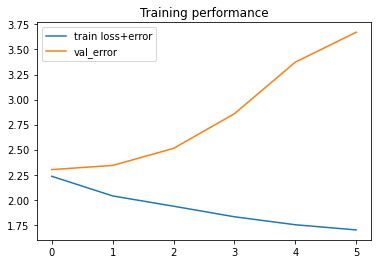

In [12]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [13]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

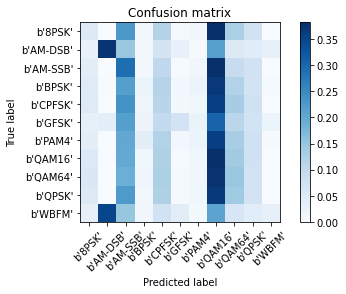

In [14]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.08948708621316842
Overall Accuracy:  0.09726775956284153
Overall Accuracy:  0.0851598993891484
Overall Accuracy:  0.08749544294567992
Overall Accuracy:  0.09097370291400142
Overall Accuracy:  0.09687953555878084
Overall Accuracy:  0.0948905109489051
Overall Accuracy:  0.10293584632113084
Overall Accuracy:  0.13484398216939078
Overall Accuracy:  0.16170058139534885
Overall Accuracy:  0.19243986254295534
Overall Accuracy:  0.20618927671824397
Overall Accuracy:  0.20215827338129497
Overall Accuracy:  0.20648527767424524
Overall Accuracy:  0.21545584045584046
Overall Accuracy:  0.23593466424682397
Overall Accuracy:  0.20222634508348794
Overall Accuracy:  0.20954003407155025
Overall Accuracy:  0.2177858439201452
Overall Accuracy:  0.21968365553602812


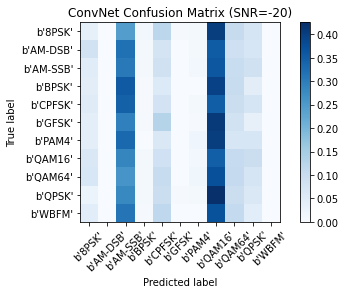

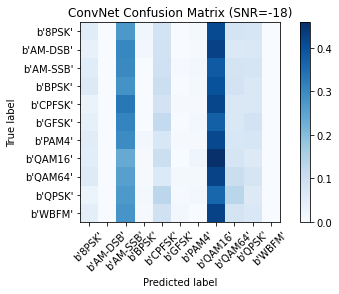

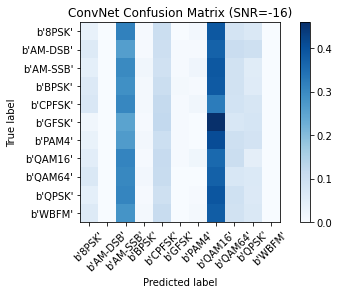

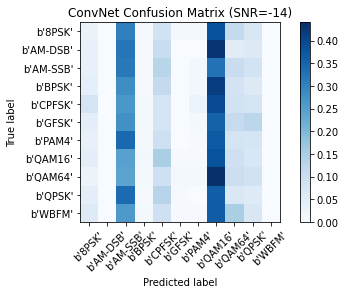

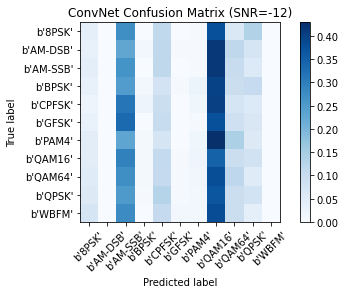

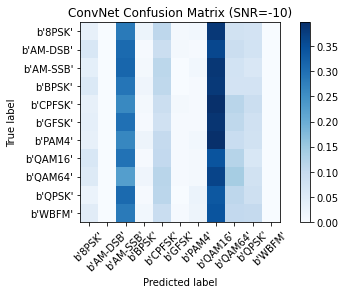

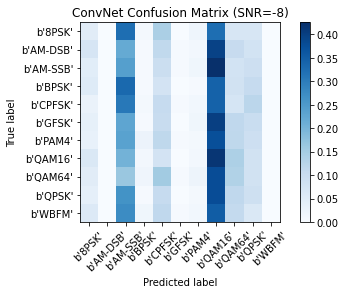

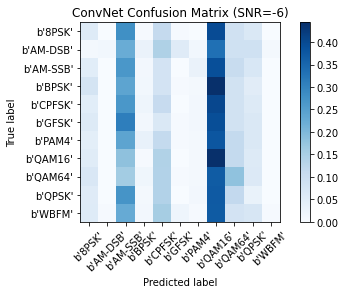

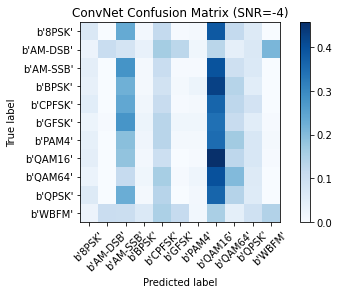

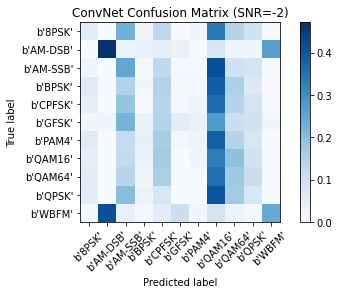

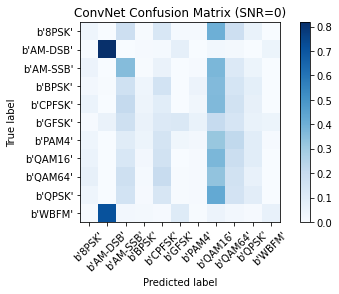

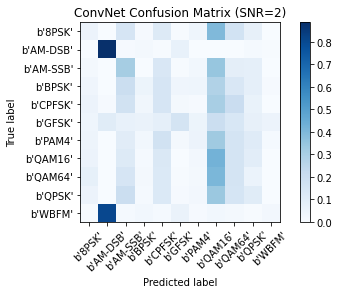

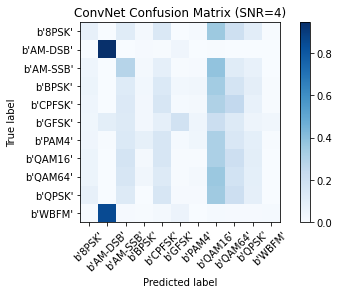

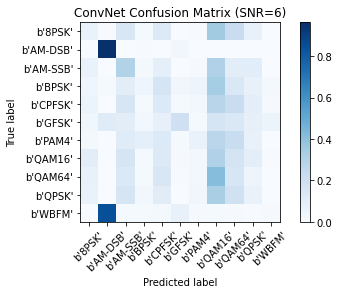

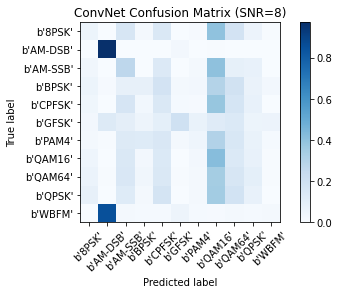

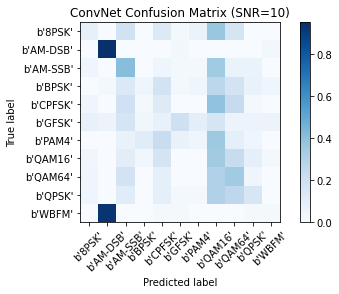

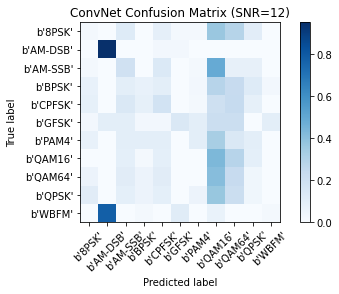

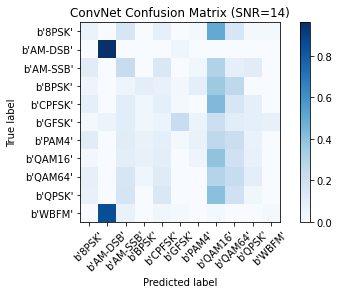

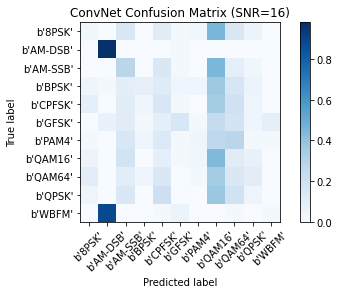

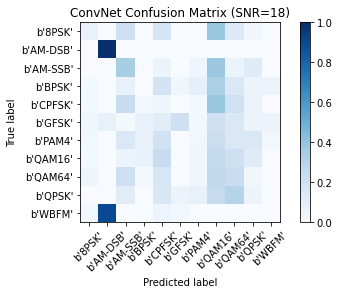

In [15]:
# Plot confusion matrix
acc = {}

for snr in snrs:
    # extract classes @ SNR
    test_SNRs = map(lambda x: labels[x][1], test_index)
    this_snr_indexes = np.where(np.array(list(test_SNRs))==snr)

    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])

    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [16]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.08948708621316842, -18: 0.09726775956284153, -16: 0.0851598993891484, -14: 0.08749544294567992, -12: 0.09097370291400142, -10: 0.09687953555878084, -8: 0.0948905109489051, -6: 0.10293584632113084, -4: 0.13484398216939078, -2: 0.16170058139534885, 0: 0.19243986254295534, 2: 0.20618927671824397, 4: 0.20215827338129497, 6: 0.20648527767424524, 8: 0.21545584045584046, 10: 0.23593466424682397, 12: 0.20222634508348794, 14: 0.20954003407155025, 16: 0.2177858439201452, 18: 0.21968365553602812}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

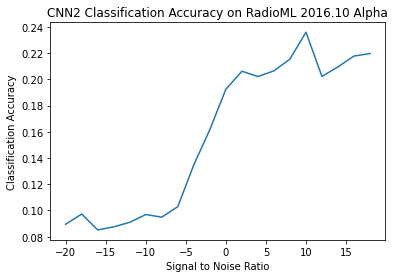

In [17]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")